In [1]:
import pandas as pd
import matplotlib.pyplot as plt

path = "youtube_comments_climate_change/cleaned_data.csv"
data = pd.read_csv(path, sep=",", encoding='utf-8', index_col=[0])

list(data.columns)

['publishedAt', 'authorName', 'text', 'isReply', 'cleaned']

In [2]:
import numpy as np
import matplotlib.pyplot as plt

embeddings = np.load('embeddings.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [53]:
import umap

n_neighbors = 50
min_dist = 1
n_components = 100

reduced_embeddings = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components
).fit_transform(embeddings)

In [54]:
#np.save('reduced_umap_100.npy', reduced_embeddings, allow_pickle=True, fix_imports=True)

In [3]:
reduced_embeddings = np.load('reduced_umap_100.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

sc = StandardScaler()
scaled_embeddings = sc.fit_transform(normalize(reduced_embeddings, norm='l2'))

In [42]:
import numpy as np
from sklearn.metrics.pairwise import cosine_distances

def cos_sim(input_vectors):
    similarity = cosine_distances(input_vectors)
    return similarity

cosine_similarity_matrix = cos_sim(np.array(scaled_embeddings))
print(cosine_similarity_matrix)

[[0.         1.1027297  1.0235087  ... 1.1995262  0.73730826 0.34464002]
 [1.1027297  0.         0.8537203  ... 0.03100592 1.2250926  1.1448183 ]
 [1.0235087  0.8537203  0.         ... 0.9589257  0.93018407 0.83591676]
 ...
 [1.1995262  0.03100592 0.9589257  ... 0.         1.1875216  1.2267058 ]
 [0.73730826 1.2250926  0.93018407 ... 1.1875216  0.         0.49339896]
 [0.34464002 1.1448183  0.83591676 ... 1.2267058  0.49339896 0.        ]]


In [43]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=100) # results remain roughly the same with n_neighbors<100
nbrs = neigh.fit(cosine_similarity_matrix)
distances, indices = nbrs.kneighbors(cosine_similarity_matrix)

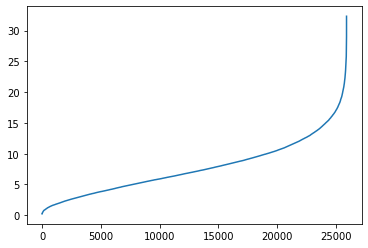

In [44]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [57]:
import math

def calculate_kn_distance(X,k):

    kn_distance = []
    for i in range(len(X)):
        eucl_dist = []
        for j in range(len(X)):
            eucl_dist.append(
                math.sqrt(
                    ((X[i,0] - X[j,0]) ** 2) +
                    ((X[i,1] - X[j,1]) ** 2)))

        eucl_dist.sort()
        kn_distance.append(eucl_dist[k])

    return kn_distance

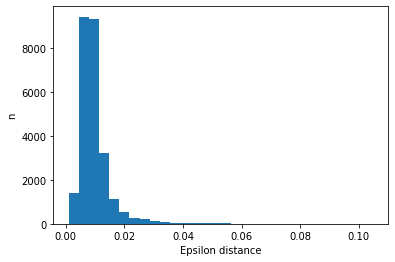

In [58]:
eps_dist = calculate_kn_distance(cosine_similarity_matrix,5)
plt.hist(eps_dist,bins=30)
plt.ylabel('n');
plt.xlabel('Epsilon distance');

In data set, majority of points lie within 0.6 units from their 5th nearest neighbor. A heuristic approach could be choosing 0.6 as DBSCAN epsilon (HDBSCAN cluster_selection_epsilon) parameter.

## KMedoids

param max_iter hab ich schon mal getuned

In [ ]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_samples, silhouette_score

kmedoids_inertia, kmedoids_silhouette = {}, {}
init_param = 'k-medoids++'
random_state_param=1234
for i in range(1,26):
    kmedoids_clustering = KMedoids(n_clusters=i, metric='cosine', max_iter=100, init=init_param, random_state=random_state_param).fit(reduced_embeddings)
    kmedoids_inertia[i] = kmedoids_clustering.inertia_
    kmedoids_labels = kmedoids_clustering.labels_
    kmedoids_silhouette[i] = silhouette_score(reduced_embeddings, kmedoids_labels)
    print("n_iterations: {} inertia: {} silhouette score: {}".format(i, kmedoids_inertia[i], kmedoids_silhouette[i] ))

sns.lineplot(data=inertias)

## Agglomerative Clustering

Recursively merges the pair of clusters that minimally increases a given linkage distance.

**Parameters:**
- Distance function
- Linkage-criterion: ward, single, average..
- Distance threshold
- linkage cannot be ward with cosine distance
- n of clusters must be None if distance_threshold is not None

Choosing distance threshold param with help of dendrogram and distance matrix.

**Experiments:**
- with distance_threshold 0.5, n_clusters None, euclidean distance, ward affinity: ~20000 clusters with max 14 members
- with distance_threshold 0,4,0.5, 0.6, n_clusters None, cosine distance, average affinity: 1 cluster

!!! Downstream tasks

In [6]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

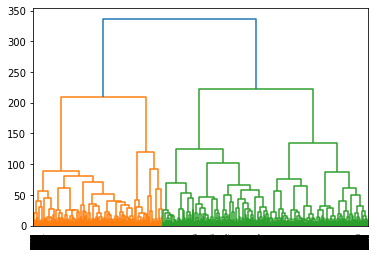

In [23]:
dendrogram = sch.dendrogram(sch.linkage(reduced_embeddings, method='ward'))

In [32]:
Z = sch.linkage(reduced_embeddings, 'ward')

In [33]:
Z_average = sch.linkage(reduced_embeddings, 'average')

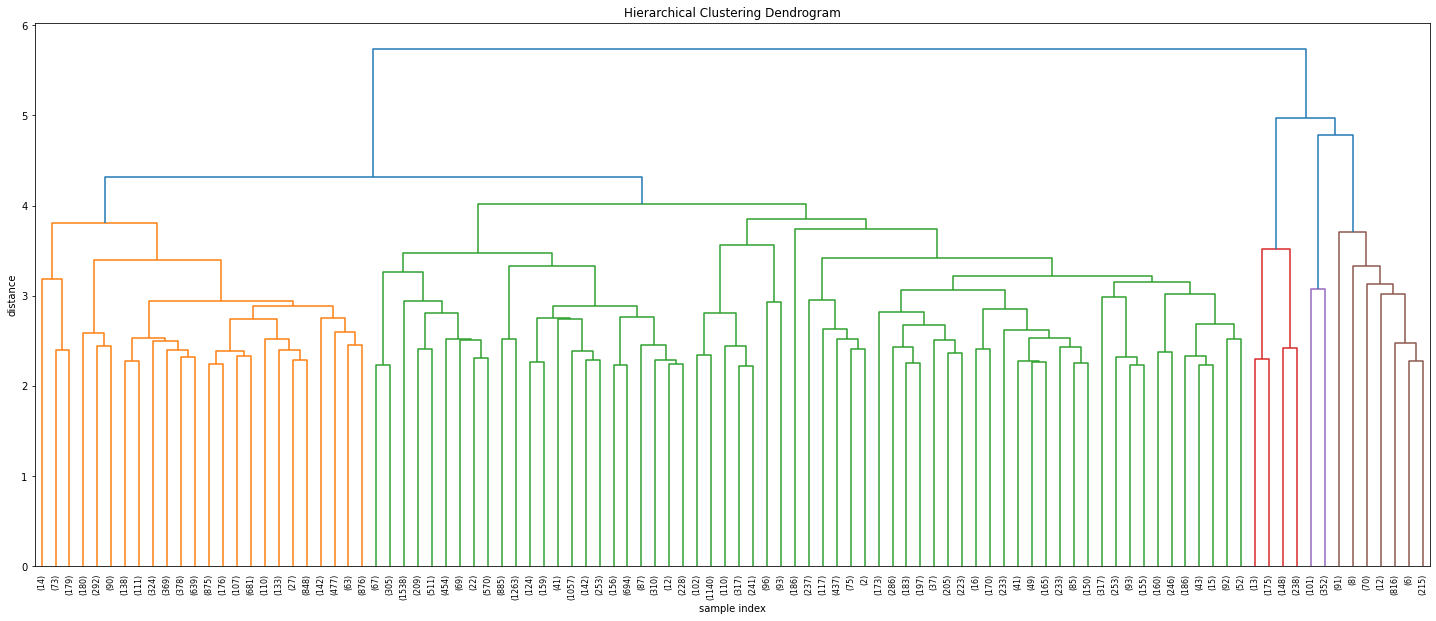

In [40]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
sch.dendrogram(
    Z_average,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=100,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [27]:
clustering = AgglomerativeClustering(
    distance_threshold=None,
    n_clusters=6,
    affinity='euclidean',
    linkage='ward'
).fit(reduced_embeddings)

In [32]:
data['labels_agglomerative'] = clustering.labels_

In [33]:
clustering.labels_

array([ 3, 16,  0, ..., 16, 13,  7])

In [34]:
silhouette_score(reduced_embeddings, clustering.labels_)

0.15949504

In [17]:
(unique, counts) = np.unique(clustering.labels_, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies_chart= frequencies[frequencies[:,0].argsort()]

frequencies_chart

array([[    0, 25914]])

In [35]:
import umap 

n_neighbors = 50
min_dist = 0.1
n_components = 2

d2_embeddings = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components
).fit_transform(reduced_embeddings)

In [36]:
silhouette_score(d2_embeddings, clustering.labels_)

0.115113705

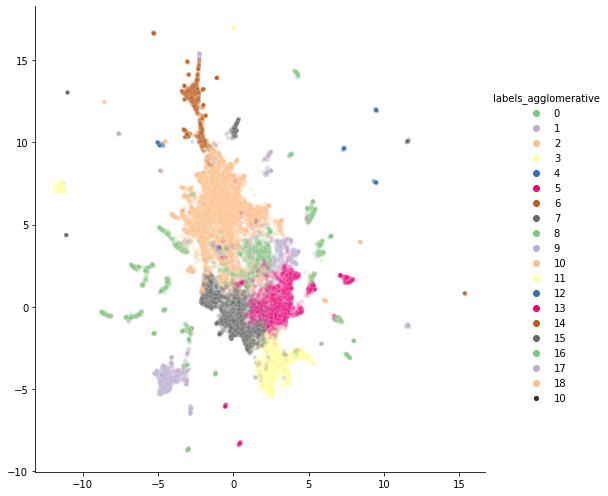

In [43]:
import seaborn as sns

palette_param = "Accent"
alpha_param = 0.2


sns.relplot(x = d2_embeddings[:, 0], y = d2_embeddings[:, 1], size = 10, hue = data["labels_agglomerative"], palette = palette_param,alpha = alpha_param,height = 7)

In [44]:
# Choose a cluster to print
cluster_number = 11
# Choose the number of samples to print
number_of_samples_to_print = 1000

data['labels_agglomerative'] = data['labels_agglomerative'].astype('category')
cluster = data[data['labels_agglomerative']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

print("Number of samples in the cluster:", cluster["text"].count())
cluster

Number of samples in the cluster: 351


,publishedAt,authorName,text,isReply,cleaned,labels_agglomerative
211,2019-12-01 19:51:18,SPG 195,Me: Uh oh...... \nUSA: \nChina: \nUnited Ki...,0,Me: Uh oh...... \nUSA: \nChina: \nUnited do...,11
254,2019-11-23 18:18:53,Frank,Venezuela Colombia Ecuador centró America ?😟😒\n\n,0,Venezuela Colombia Ecuador centró ?😟😒\n\n,11
526,2019-10-22 11:34:23,Loko Random,Nenhum Br ? Como assim produção hrheheh\n\n,0,Nenhum Br ? Como assim produção hrheheh\n\n,11
983,2019-08-28 00:10:34,Paulo Maurício,O bom é que cuba desaparece\n\n,0,O bom é que cuba desaparece\n\n,11
1077,2019-08-10 19:15:17,Valenvivo_07,NO MAN TREMENDO COMO ME CHUPA 3 HUEVOS BRO\n\n,0,NO MAN TREMENDO COMO ME CHUPA 3 HUEVOS BRO\n\n,11
...,...,...,...,...,...,...
25624,2015-04-09 20:59:12,bastiboy,@wsalinas1 que estupido tu comentario\n\n,1,@ que estupido tu comentario\n\n,11
25625,2015-04-09 03:04:06,wsalinas1,"@Winmet Viat Ohhh...! Pero.., por si acaso,, a...",1,"@Winmet Viat Ohhh...! Pero.., por si acaso,, a...",11
25626,2015-04-05 15:39:53,Scott Andrew Biederer Czajkowski,si la tierra se inundara 5.000 metros ahi seri...,1,si la tierra se inundara 5.000 metros ahi seri...,11
25628,2015-04-05 01:12:20,Scott Andrew Biederer Czajkowski,@wsalinas1 Chile no desaparece porq esta sobre...,1,@ Chile no desaparece porq esta sobre 600 metr...,11


In [30]:
from sklearn.metrics import silhouette_samples, silhouette_score

s_scores = {}

for i in range(2,20):
    clustering = AgglomerativeClustering(
        distance_threshold=None,
        n_clusters=i,
        affinity='cosine',
        linkage='average'
    ).fit(reduced_embeddings)
    
    labels = clustering.labels_
    s_scores[i] = silhouette_score(reduced_embeddings, labels)
    print("The silhouette score with {} clusters: {}".format(i, s_scores[i]))

The silhouette score with 2 clusters: 0.3218092620372772
The silhouette score with 3 clusters: 0.27637171745300293
The silhouette score with 4 clusters: 0.24365170300006866
The silhouette score with 5 clusters: 0.17656180262565613
The silhouette score with 6 clusters: 0.2069859355688095
The silhouette score with 7 clusters: 0.1925605833530426
The silhouette score with 8 clusters: 0.18324987590312958
The silhouette score with 9 clusters: 0.18156224489212036
The silhouette score with 10 clusters: 0.19185255467891693
The silhouette score with 11 clusters: 0.1748921126127243
The silhouette score with 12 clusters: 0.15913604199886322
The silhouette score with 13 clusters: 0.16093485057353973
The silhouette score with 14 clusters: 0.15942105650901794
The silhouette score with 15 clusters: 0.15214063227176666
The silhouette score with 16 clusters: 0.14991645514965057
The silhouette score with 17 clusters: 0.16482111811637878
The silhouette score with 18 clusters: 0.16246286034584045
The silho

In [45]:
from sklearn.metrics import silhouette_samples, silhouette_score

s_scores = {}

for i in range(2,21):
    clustering = AgglomerativeClustering(
        distance_threshold=None,
        n_clusters=i,
        affinity='euclidean',
        linkage='ward'
    ).fit(reduced_embeddings)
    
    labels = clustering.labels_
    s_scores[i] = silhouette_score(reduced_embeddings, labels)
    print("The silhouette score with {} clusters: {}".format(i, s_scores[i]))

The silhouette score with 2 clusters: 0.21313004195690155
The silhouette score with 3 clusters: 0.17260374128818512
The silhouette score with 4 clusters: 0.19136324524879456
The silhouette score with 5 clusters: 0.1702442616224289
The silhouette score with 6 clusters: 0.1670326590538025
The silhouette score with 7 clusters: 0.17496366798877716
The silhouette score with 8 clusters: 0.1718408763408661
The silhouette score with 9 clusters: 0.17648686468601227
The silhouette score with 10 clusters: 0.1511068493127823
The silhouette score with 11 clusters: 0.14428994059562683
The silhouette score with 12 clusters: 0.13603809475898743
The silhouette score with 13 clusters: 0.13662652671337128
The silhouette score with 14 clusters: 0.14172209799289703
The silhouette score with 15 clusters: 0.14011821150779724
The silhouette score with 16 clusters: 0.14310714602470398
The silhouette score with 17 clusters: 0.13990670442581177
The silhouette score with 18 clusters: 0.14376282691955566
The silho

## Density-based clustering

### HDBSCAN

HDBSCAN extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters. 

**Assumptions:** noisy data, clusters we would like to uncover

What actually happens? We can break it out into a series of steps:

1) Transform the space according to the density/sparsity.

2) Build the minimum spanning tree of the distance weighted graph.

3) Construct a cluster hierarchy of connected components.

4) Condense the cluster hierarchy based on minimum cluster size.

5) Extract the stable clusters from the condensed tree.

**Parameters:**

min_samples: larger values -> more data is labelled as noise

min_cluster_size: smallest group to be considered a cluster

cluster_selection_epsilon: eps from DBSCAN: max distance between two samples for them to be considered as in a neigborhood, default=0.5


!! Too many clusters to compare, clusters make sense in itself, noisy comments are not just comments that have one word

The most likely explanation is to do with the dimensionality of your input data. While HDBSCAN can perform well on low to medium dimensional data the performance tends to decrease significantly as dimension increases. In general HDBSCAN can do well on up to around 50 or 100 dimensional data, but performance can see significant decreases beyond that. Of course a lot is also dataset dependent, so you can still get good performance even on high dimensional data, but it is no longer guaranteed

In [38]:
import hdbscan

labels = hdbscan.HDBSCAN(
    min_cluster_size=30,
    cluster_selection_epsilon=0.8
).fit_predict(reduced_embeddings)

In [21]:
hdbscan = hdbscan.HDBSCAN(
    min_cluster_size=30,
).fit(reduced_embeddings)

<AxesSubplot:ylabel='$\\lambda$ value'>

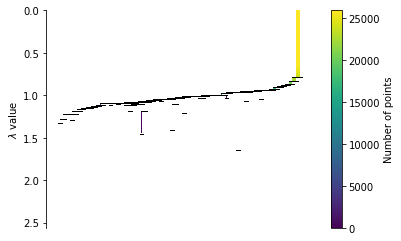

In [25]:
hdbscan.condensed_tree_.plot()

The HDBSCAN object now has an attribute (computed when first accessed) called outlier_scores_. This provides a numpy array with a value for each sample in the original dataset that was fit with the clusterer. The higher the score, the more likely the point is to be an outlier. In practice it is often best to look at the distributions of outlier scores.

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

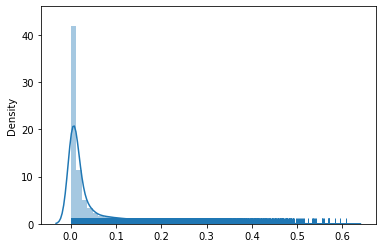

In [34]:
sns.distplot(hdbscan.outlier_scores_[np.isfinite(hdbscan.outlier_scores_)], rug=True)

In [39]:
data['labels_hdbscan'] = labels

In [40]:
(unique, counts) = np.unique(labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies_chart= frequencies[frequencies[:,0].argsort()]

frequencies_chart

array([[   -1, 17321],
       [    0,    75],
       [    1,   162],
       [    2,   206],
       [    3,    80],
       [    4,    33],
       [    5,    51],
       [    6,    84],
       [    7,   170],
       [    8,   112],
       [    9,   180],
       [   10,   129],
       [   11,    41],
       [   12,    39],
       [   13,   295],
       [   14,    62],
       [   15,    77],
       [   16,    89],
       [   17,    61],
       [   18,   147],
       [   19,    74],
       [   20,   150],
       [   21,   110],
       [   22,   367],
       [   23,    64],
       [   24,    68],
       [   25,    61],
       [   26,   142],
       [   27,   121],
       [   28,    77],
       [   29,   151],
       [   30,    76],
       [   31,   185],
       [   32,    95],
       [   33,   639],
       [   34,    78],
       [   35,   138],
       [   36,    40],
       [   37,    42],
       [   38,   859],
       [   39,   120],
       [   40,   152],
       [   41,    85],
       [   

<BarContainer object of 58 artists>

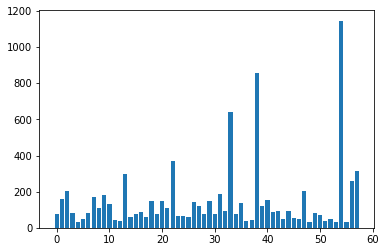

In [41]:
import matplotlib.pyplot as plt

plt.bar(frequencies[1:,0], frequencies[1:,1]) #excluding noise

In [42]:
n_neighbors = 50
min_dist = 0.1
n_components = 2

d2_embeddings = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components
).fit_transform(reduced_embeddings)

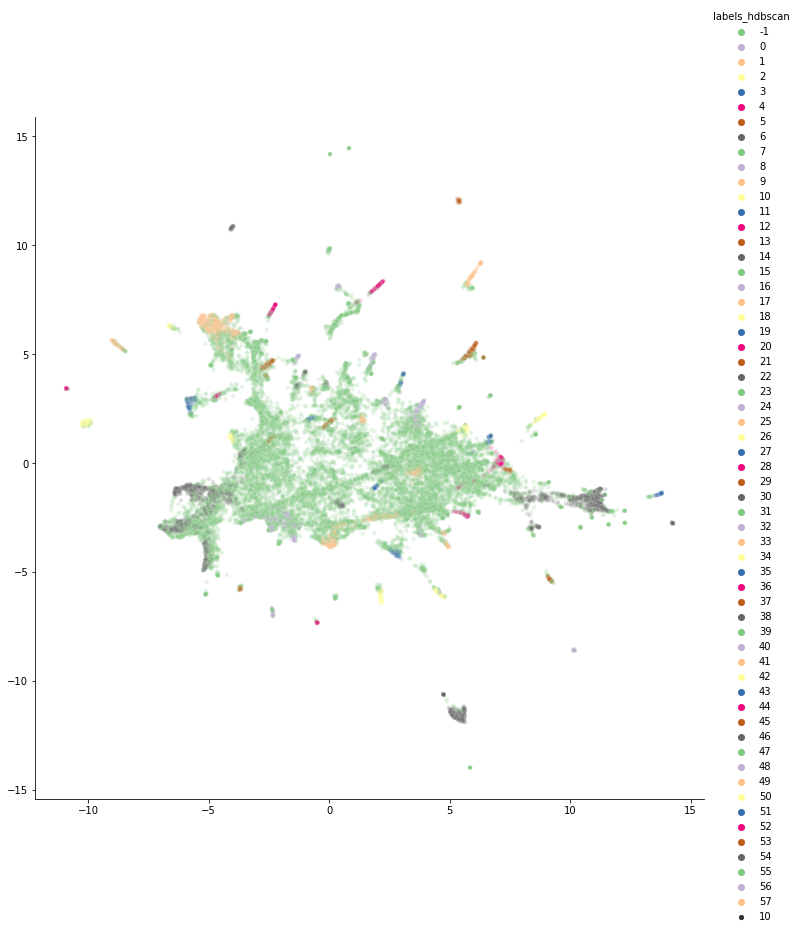

In [43]:
import seaborn as sns

palette_param = "Accent"
alpha_param = 0.2


sns.relplot(x = d2_embeddings[:, 0], y = d2_embeddings[:, 1], size = 10, hue = data["labels_hdbscan"], palette = palette_param,alpha = alpha_param,height = 10)

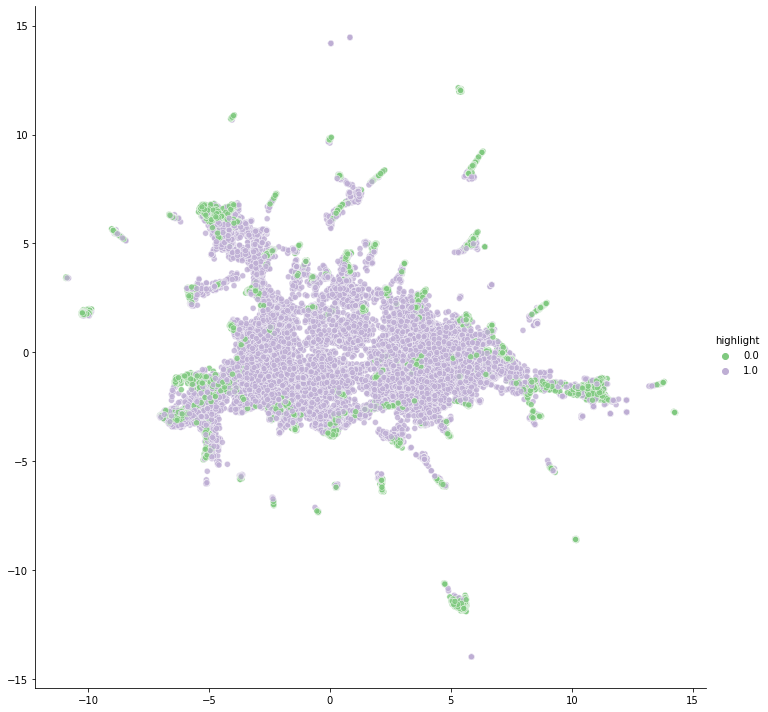

In [44]:
cluster_num = -1
data['highlight'] = np.zeros(len(data.index))
data.loc[data['labels_hdbscan'] == cluster_num, 'highlight'] = 1

sns.relplot(x = d2_embeddings[:, 0], y = d2_embeddings[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)

In [45]:
# Choose a cluster to print
cluster_number = -1
# Choose the number of samples to print
number_of_samples_to_print = 1000

data['labels_hdbscan'] = data['labels_hdbscan'].astype('category')
cluster = data[data['labels_hdbscan']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

print("Number of samples in the cluster:", cluster["text"].count())
cluster

Number of samples in the cluster: 17321


,publishedAt,authorName,text,isReply,cleaned,labels_hdbscan,highlight
0,2020-01-16 09:01:08,Lee McLellan,If all the ice melts surely the tilt of the ea...,0,If all the ice melts surely the tilt of the ea...,-1,1.0
3,2020-01-15 08:35:50,Shane Meyer,Step #1: Taxes... Step #2: ???... Step #3: Uto...,0,Step #1: Taxes... Step #2: ???... Step #3: Uto...,-1,1.0
4,2020-01-15 02:00:30,Rennie Allen,Strange how Hudson's Bay stayed the same size....,0,Strange how Hudson's Bay stayed the same size....,-1,1.0
6,2020-01-14 20:21:36,Josué Oller,Brazil will lost 25% of territory 😂\n\n,0,will lost 25% of territory 😂\n\n,-1,1.0
7,2020-01-14 14:48:03,Someonelse doodles,Lesson learned : dont put your capitol city ne...,0,Lesson learned : dont put your capitol city ne...,-1,1.0
...,...,...,...,...,...,...,...
25910,2015-04-03 00:11:16,Gabriel Estéban Muñoz,@Eknut .X Or South America\n\n,1,@ Or \n\n,-1,1.0
25911,2015-04-02 19:51:29,Eknut .X,@metimoteo HAHAHA!!\n\n,1,@ HAHAHA!!\n\n,-1,1.0
25913,2015-03-01 20:21:57,Senso Rieskin,And tought it would be a big deal. Plenty land...,0,And tought it would be a big deal. Plenty land...,-1,1.0
25914,2015-02-26 18:03:44,roboticreality,Scary! Music helped but still.\n\n,0,Scary! Music helped but still.\n\n,-1,1.0
